** JM**
Máster Data Science ENAE CURSO 2024/2025

# 0. Previa. Librerías generales

In [217]:
%%capture
!pip install tensorflow=='2.3.0' keras=='2.3.1' numpy=='1.18.5'
!pip install ydata-profiling --upgrade

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
import keras

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

%matplotlib inline
import matplotlib as mpl
mpl.rc("figure, fgsize=(16, 9)")


# 1. Cargar los datos

In [219]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [220]:
!ls "/content/drive/MyDrive/Colab Notebooks/01-DL-ML"

 2025_Fine_Tunning_LLMs_con_LoRA.ipynb
 2025_RAG_Example.ipynb
 airfoil_self_noise.csv
 Artiles_Suarez_JoseMiguel_CasopracticoFinal_DL.ipynb
 EjemploSimilarEntrega.ipynb
 ENAE_Agents_CrewAI.ipynb
 model.h5
'Primera_Red_Neuronal copia.ipynb'
 test_v2.csv
 train_v2.csv


In [221]:
train_path = "/content/drive/MyDrive/Colab Notebooks/01-DL-ML/train_v2.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/01-DL-ML/test_v2.csv"



In [222]:
# Cargar los datos de entrenamiento y test
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/01-DL-ML/test_v2.csv", header=0)
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/01-DL-ML/train_v2.csv", header=0)


Apunte: fundamental a la hora de cargar el archivo .csv (header=0)

# 2. Análisis exploratorio

In [223]:
# Verificar valores faltantes en train_df
print("Valores faltantes en train_df:")
print(train_df.isnull().sum())

# Verificar valores faltantes en test_df
print("Valores faltantes en test_df:")
print(test_df.isnull().sum())

Valores faltantes en train_df:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      173
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64
Valores faltantes en test_df:
Id                0
MSSubClass        0
MSZoning          0
LotFrontage      86
LotArea           0
                 ..
MoSold            0
YrSold            0
SaleType          0
SaleCondition     0
SalePrice         0
Length: 81, dtype: int64


In [224]:

# Ver las primeras filas de ambos datasets
print("Datos de entrenamiento:")
print(train_df.head())

print("\nDatos de prueba:")
print(test_df.head())

Datos de entrenamiento:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice

In [225]:
# Separar características (X_train) y variable objetivo (y_train)
X_train = train_df.drop(columns=['SalePrice'])  # Características
y_train = train_df['SalePrice']                # Variable objetivo

print("X_train y y_train han sido creados correctamente.")

X_train y y_train han sido creados correctamente.


In [226]:
# Asignar test_df a X_test
X_test = test_df

print("X_test ha sido creado correctamente.")

X_test ha sido creado correctamente.


In [227]:
# Asegurarnos de que X_test tenga las mismas columnas que X_train
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Agregar columnas faltantes con valor 0

# Reordenamiento de las columnas de X_test para que coincidan con X_train
X_test = X_test[X_train.columns]

print("Estructura de X_test ajustada para coincidir con X_train.")

Estructura de X_test ajustada para coincidir con X_train.


In [228]:
#Realizaremos un análisis exploratorio inicial para comprender mejor los datos. Esto incluye:

# Buscar valores faltantes.
# Detectar filas duplicadas.
# Calcular estadísticos descriptivos

# Verificar si hay valores faltantes
print("\nValores faltantes en train:")
print(train_df.isnull().sum())

print("\nValores faltantes en test:")
print(test_df.isnull().sum())

# Verificar si hay filas duplicadas
print("\nFilas duplicadas en train:", train_df.duplicated().sum())
print("Filas duplicadas en test:", test_df.duplicated().sum())

# Estadísticos
print("\nEstadísticos de train:")
print(train_df.describe())

print("\nEstadísticos de test:")
print(test_df.describe())


Valores faltantes en train:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      173
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

Valores faltantes en test:
Id                0
MSSubClass        0
MSZoning          0
LotFrontage      86
LotArea           0
                 ..
MoSold            0
YrSold            0
SaleType          0
SaleCondition     0
SalePrice         0
Length: 81, dtype: int64

Filas duplicadas en train: 0
Filas duplicadas en test: 0

Estadísticos de train:
               Id  MSSubClass  LotFrontage        LotArea  OverallQual  \
count  999.000000  999.000000   826.000000     999.000000   999.000000   
mean   500.000000   56.916917    69.962470   10695.109109     6.124124   
std    288.530761   42.261403    23.215821   11417.706546     1.383632   
min      1.000000   20.000000    21.000000    1300.000000     1.

# 3. Ingeniería de variables: crear una variable (OPCIONAL)

Voy a crear una variable ficticia con los valores de la columna Yrsold, con la idea de que a más nueva sea la vivienda, multiplique algo su valor

In [229]:
# Ver los valores únicos en la columna YrSold
unique_years_sold = train_df['YrSold'].unique()

print("Valores únicos en la columna YrSold:")
print(unique_years_sold)

# También puedes ordenar los valores únicos para mayor claridad
sorted_years_sold = sorted(unique_years_sold)
print("\nValores únicos ordenados:")
print(sorted_years_sold)

Valores únicos en la columna YrSold:
[2008 2007 2006 2009 2010]

Valores únicos ordenados:
[np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010)]


Ahora vamos a crear una variable ficticia que de valor a las casas nuevas, dandole una puntuación

In [230]:
import numpy as np

# Cálculo de la antigüedad de la casa
train_df['House_Age'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['House_Age'] = test_df['YrSold'] - test_df['YearBuilt']

# Definir un parámetro de depreciación
k = 0.05  # Este valor se puede modificar según lo que se estime

# Crear el score de "Novedad (Newness)" usando una función exponencial
train_df['House_Newness_Score'] = np.exp(-k * train_df['House_Age'])
test_df['House_Newness_Score'] = np.exp(-k * test_df['House_Age'])

print("Variable continua 'House_Newness_Score' creada correctamente.")

Variable continua 'House_Newness_Score' creada correctamente.


In [231]:
# Ver las primeras filas del DataFrame con la nueva columna
print(train_df[['YearBuilt', 'YrSold', 'House_Age', 'House_Newness_Score']].head())

# Resumen estadístico de la nueva variable
newness_summary = train_df['House_Newness_Score'].describe()
print("\nResumen estadístico de 'House_Newness_Score':")
print(newness_summary)

   YearBuilt  YrSold  House_Age  House_Newness_Score
0       2003    2008          5             0.778801
1       1976    2007         31             0.212248
2       2001    2008          7             0.704688
3       1915    2006         91             0.010567
4       2000    2008          8             0.670320

Resumen estadístico de 'House_Newness_Score':
count    999.000000
mean       0.356517
std        0.347636
min        0.001581
25%        0.067206
50%        0.182684
75%        0.670320
max        1.000000
Name: House_Newness_Score, dtype: float64


In [232]:
#Ahora planteamos la operación similar con la variable SaleCondition

# Ver las rimeras filas para identificar las columnas
print(train_df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... Fence MiscFeature MiscVal MoSold YrSold SaleType  \
0         Lvl    AllPub  ...   NaN         NaN       0      2   2008       WD   
1         Lvl    AllPub  ...   NaN         NaN       0      5   2007       WD   
2         Lvl    AllPub  ...   NaN         NaN       0      9   2008       WD   
3         Lvl    AllPub  ...   NaN         NaN       0      2   2006       WD   
4         Lvl    AllPub  ...   NaN         NaN       0     12   2008       WD   

  SaleCondition  SalePrice  House_Age  House_Newness_Score  
0      

In [233]:
#Comprobamos la columna

# Acceder a la columna SaleCondition por su nombre
unique_sale_conditions = train_df['SaleCondition'].unique()

print("Valores únicos en la columna SaleCondition:")
print(unique_sale_conditions)

Valores únicos en la columna SaleCondition:
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


Observando la tipología de los datos, vamos a crear una variable dummy para cada una situación distinta de las viviendas, y luego la incluiremos en el modelo de regresión


*   Normal: venta estandár
*   Abnormal: venta fuera de lo común, situaciones especiales
*   Partial: venta parcial
*   AdjLand: tiene terrenos anexos adyacentes
*   Alloca: operación entre partes relacionadas (empresas, familias), desvirtua el análisis
*   Family: la propiedad fue transferida dentro de la familia




In [234]:
#Asignamos una variable numérica a cada situación posible, para visualizar el impacto sobre el precio

# Mapeamos las categorías a valores numéricos
# La asignación de los valores es parcial, teniendo en cuenta las situaciones
# Asignamos una variable numérica a cada situación posible, para visualizar el impacto sobre el precio

sale_condition_impacto = {
    'Normal': 1.0,
    'Abnorml': -0.7,
    'Partial': 0.6,
    'AdjLand': 1.5,
    'Alloca': 0.6,
    'Family': 0.6
}

# Usamos el nombre de la columna en lugar del índice numérico
train_df['SaleConditionImpacto'] = train_df['SaleCondition'].map(sale_condition_impacto)
test_df['SaleConditionImpacto'] = test_df['SaleCondition'].map(sale_condition_impacto)

# Mostrar las primeras filas con la nueva variable
print(train_df[['SaleCondition', 'SaleConditionImpacto']].head())

  SaleCondition  SaleConditionImpacto
0        Normal                   1.0
1        Normal                   1.0
2        Normal                   1.0
3       Abnorml                  -0.7
4        Normal                   1.0


# 4. Eliminar las variables de entrada no numéricas

Eliminar las variables de entrada no numéricas,también está admitido utilizar técnicas de label encoder o parecidos para transformar los textos en números

In [235]:
# Como primer paso, identificación de variables no numéricas (categóricas)
non_numeric_cols = train_df.select_dtypes(include=['object']).columns

print("Variables no numéricas en train_df:")
print(non_numeric_cols)

# Verificar si test_df tiene las mismas variables no numéricas
test_non_numeric_cols = test_df.select_dtypes(include=['object']).columns

print("\nVariables no numéricas en test_df:")
print(test_non_numeric_cols)

Variables no numéricas en train_df:
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Variables no numéricas en test_df:
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType',

En primer lugar, se deciden eliminar las variables Alley (representa el acceso al callejón trasero, y tiene exceso de valores NA), la variable Utilities (es el acceso a los suministros, es casi una constante), la variable FireplaceQ (si disponen de chimenea, muchisimos valores NA en la columna), la variable Fence (valla, muchísimos valores NA), y la variable MiscFeature (significa cosas extras en la propiedad, presenta muchos NA en las columnas)

Igualmente, se consideran eliminar las variables PoolQc (muchisimos NA), GarageQual y GarageCond (hay otras variables que relacionan el garage), BsmtFinType2 y BsmtFinType1 (el acabado del sótano, ya hay otras que lo indican), Condition1 y Condition2 (mismo caso), RoofMap (material de techo sin apenas variabilidad). Se elimina tambien LotFrontage.

In [236]:
# Lista de variables a eliminar
columns_to_drop = [
    'Alley', 'Utilities', 'FireplaceQu', 'Fence', 'MiscFeature',  # Variables previamente seleccionadas
    'PoolQC', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2',  # Variables adicionales
    'Condition1', 'Condition2', 'RoofMatl','LotFrontage'
]

# Verificar si las columnas existen antes de eliminarlas
existing_columns = [col for col in columns_to_drop if col in train_df.columns]

# Eliminar las columnas de train_df y test_df
train_df = train_df.drop(columns=existing_columns)
test_df = test_df.drop(columns=existing_columns)

print(f"Columnas eliminadas: {existing_columns}")

# Mostrar las columnas restantes
print("\nColumnas en train_df después de eliminar:")
print(train_df.columns)

print("\nColumnas en test_df después de eliminar:")
print(test_df.columns)

Columnas eliminadas: ['Alley', 'Utilities', 'FireplaceQu', 'Fence', 'MiscFeature', 'PoolQC', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2', 'Condition1', 'Condition2', 'RoofMatl', 'LotFrontage']

Columnas en train_df después de eliminar:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',

In [237]:
#Antes de seguir limpiando, se comprueba la correlación de las variables ficticias

print(train_df[['YearBuilt', 'YrSold', 'House_Newness_Score']].corr())

                     YearBuilt    YrSold  House_Newness_Score
YearBuilt             1.000000  0.009420             0.866252
YrSold                0.009420  1.000000            -0.070018
House_Newness_Score   0.866252 -0.070018             1.000000


In [238]:
# Eliminamos variables originales
original_vars_to_drop = ['YearBuilt', 'YrSold']

# Comproba si las columnas existen antes de eliminarlas
existing_columns = [col for col in original_vars_to_drop if col in train_df.columns]

# Eliminar las columnas de train_df y test_df
train_df = train_df.drop(columns=existing_columns)
test_df = test_df.drop(columns=existing_columns)

print(f"Variables eliminadas: {existing_columns}")

# Mostrar las columnas restantes
print("\nColumnas en train_df después de eliminar:")
print(train_df.columns)

print("\nColumnas en test_df después de eliminar:")
print(test_df.columns)

Variables eliminadas: ['YearBuilt', 'YrSold']

Columnas en train_df después de eliminar:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
 

In [239]:

# Identificar columnas categóricas
categorical_cols = train_df.select_dtypes(include=['object']).columns



In [240]:
print(train_df[categorical_cols].head())

  MSZoning Street LotShape LandContour LotConfig LandSlope Neighborhood  \
0       RL   Pave      Reg         Lvl    Inside       Gtl      CollgCr   
1       RL   Pave      Reg         Lvl       FR2       Gtl      Veenker   
2       RL   Pave      IR1         Lvl    Inside       Gtl      CollgCr   
3       RL   Pave      IR1         Lvl    Corner       Gtl      Crawfor   
4       RL   Pave      IR1         Lvl       FR2       Gtl      NoRidge   

  BldgType HouseStyle RoofStyle  ... HeatingQC CentralAir Electrical  \
0     1Fam     2Story     Gable  ...        Ex          Y      SBrkr   
1     1Fam     1Story     Gable  ...        Ex          Y      SBrkr   
2     1Fam     2Story     Gable  ...        Ex          Y      SBrkr   
3     1Fam     2Story     Gable  ...        Gd          Y      SBrkr   
4     1Fam     2Story     Gable  ...        Ex          Y      SBrkr   

  KitchenQual Functional GarageType GarageFinish PavedDrive SaleType  \
0          Gd        Typ     Attchd         

In [241]:
print("Columnas en train_df:")
print(train_df.columns)

print("\nColumnas en test_df:")
print(test_df.columns)

print("Columnas en train_df después de añadir variables ficticias:")
print(train_df.columns)

print("\nColumnas en test_df después de añadir variables ficticias:")
print(test_df.columns)

Columnas en train_df:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'SalePrice'

In [242]:
# Verificar si la columna 'SaleConditionImpacto' existe en train_df
if 'SaleConditionImpacto' in train_df.columns:
    print("La columna 'SaleConditionImpacto' existe en train_df.")

    # Mostrar las primeras filas de la columna
    print("\nPrimeras filas de 'SaleConditionImpacto' en train_df:")
    print(train_df['SaleConditionImpacto'].head())

    # Mostrar los valores únicos en la columna
    print("\nValores únicos en 'SaleConditionImpacto' en train_df:")
    print(train_df['SaleConditionImpacto'].unique())
else:
    print("La columna 'SaleConditionImpacto' NO existe en train_df.")

# Verificar si la columna 'SaleConditionImpacto' existe en test_df
if 'SaleConditionImpacto' in test_df.columns:
    print("\nLa columna 'SaleConditionImpacto' existe en test_df.")

    # Mostrar las primeras filas de la columna
    print("\nPrimeras filas de 'SaleConditionImpacto' en test_df:")
    print(test_df['SaleConditionImpacto'].head())

    # Mostrar los valores únicos en la columna
    print("\nValores únicos en 'SaleConditionImpacto' en test_df:")
    print(test_df['SaleConditionImpacto'].unique())
else:
    print("\nLa columna 'SaleConditionImpacto' NO existe en test_df.")

La columna 'SaleConditionImpacto' existe en train_df.

Primeras filas de 'SaleConditionImpacto' en train_df:
0    1.0
1    1.0
2    1.0
3   -0.7
4    1.0
Name: SaleConditionImpacto, dtype: float64

Valores únicos en 'SaleConditionImpacto' en train_df:
[ 1.  -0.7  0.6  1.5]

La columna 'SaleConditionImpacto' existe en test_df.

Primeras filas de 'SaleConditionImpacto' en test_df:
0    1.0
1    1.0
2   -0.7
3    1.0
4    1.0
Name: SaleConditionImpacto, dtype: float64

Valores únicos en 'SaleConditionImpacto' en test_df:
[ 1.  -0.7  0.6]


In [243]:
# Control de las primeras filas de train_df
print("Primeras filas de train_df:")
print(train_df.head())

# Control de las primeras filas de test_df
print("\nPrimeras filas de test_df:")
print(test_df.head())

Primeras filas de train_df:
   Id  MSSubClass MSZoning  LotArea Street LotShape LandContour LotConfig  \
0   1          60       RL     8450   Pave      Reg         Lvl    Inside   
1   2          20       RL     9600   Pave      Reg         Lvl       FR2   
2   3          60       RL    11250   Pave      IR1         Lvl    Inside   
3   4          70       RL     9550   Pave      IR1         Lvl    Corner   
4   5          60       RL    14260   Pave      IR1         Lvl       FR2   

  LandSlope Neighborhood  ... ScreenPorch PoolArea  MiscVal  MoSold  SaleType  \
0       Gtl      CollgCr  ...           0        0        0       2        WD   
1       Gtl      Veenker  ...           0        0        0       5        WD   
2       Gtl      CollgCr  ...           0        0        0       9        WD   
3       Gtl      Crawfor  ...           0        0        0       2        WD   
4       Gtl      NoRidge  ...           0        0        0      12        WD   

  SaleCondition SalePr

# 5.  Eliminar las variables de entrada que no tengan sentido lógico para realizar la predicción

Se procede a eliminar más variables que no tienen sentido en la predicción, para simplificarla

In [244]:
# Identificar columnas categóricas
categorical_cols = train_df.select_dtypes(include=['object']).columns

print("Columnas categóricas detectadas:")
print(categorical_cols)

Columnas categóricas detectadas:
Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')


In [245]:
#Debido a errores que se producen al aplicar LabelEncoder, vamos a transformar las columnas categóricas en numéricas siguiendo la estrategia anterior al crear las ficticias

# Asignar valores numéricos manualmente
material_score = {
    'VinylSd': 5, 'MetalSd': 4, 'Wd Sdng': 3, 'HdBoard': 2, 'Plywood': 1,
    'CBlock': 0, 'BrkFace': 4, 'AsbShng': 1, 'Stucco': 2, 'Stone': 5,
    'ImStucc': 3, 'CemntBd': 4, 'BrkComm': 0
}

train_df['Exterior1st'] = train_df['Exterior1st'].map(material_score)
test_df['Exterior1st'] = test_df['Exterior1st'].map(material_score)

train_df['Exterior2nd'] = train_df['Exterior2nd'].map(material_score)
test_df['Exterior2nd'] = test_df['Exterior2nd'].map(material_score)

# Asignar valores numéricos manualmente (material externo de la casa)
masonry_score = {'BrkFace': 5, 'Stone': 4, 'None': 0, 'BrkCmn': 2}

train_df['MasVnrType'] = train_df['MasVnrType'].map(masonry_score)
test_df['MasVnrType'] = test_df['MasVnrType'].map(masonry_score)

# Asignar valores numéricos manualmente (valoración del estado exterior)
quality_score = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

train_df['ExterQual'] = train_df['ExterQual'].map(quality_score)
test_df['ExterQual'] = test_df['ExterQual'].map(quality_score)

train_df['ExterCond'] = train_df['ExterCond'].map(quality_score)
test_df['ExterCond'] = test_df['ExterCond'].map(quality_score)

#Cimentación

foundation_score = {'PConc': 5, 'CBlock': 3, 'BrkTil': 2, 'Slab': 1, 'Stone': 4, 'Wood': 1}

train_df['Foundation'] = train_df['Foundation'].map(foundation_score)
test_df['Foundation'] = test_df['Foundation'].map(foundation_score)

#Calidades del sótano: # BsmtQual y BsmtCond
basement_quality_score = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

train_df['BsmtQual'] = train_df['BsmtQual'].map(basement_quality_score)
test_df['BsmtQual'] = test_df['BsmtQual'].map(basement_quality_score)

train_df['BsmtCond'] = train_df['BsmtCond'].map(basement_quality_score)
test_df['BsmtCond'] = test_df['BsmtCond'].map(basement_quality_score)

# BsmtExposure
exposure_score = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}

train_df['BsmtExposure'] = train_df['BsmtExposure'].map(exposure_score)
test_df['BsmtExposure'] = test_df['BsmtExposure'].map(exposure_score)

#Tipos de calefacción

# Eliminar Heating
train_df = train_df.drop(columns=['Heating'], errors='ignore')
test_df = test_df.drop(columns=['Heating'], errors='ignore')

# Convertir HeatingQC
heating_quality_score = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

train_df['HeatingQC'] = train_df['HeatingQC'].map(heating_quality_score)
test_df['HeatingQC'] = test_df['HeatingQC'].map(heating_quality_score)

#Electricidad
electrical_score = {'SBrkr': 5, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0}

train_df['Electrical'] = train_df['Electrical'].map(electrical_score)
test_df['Electrical'] = test_df['Electrical'].map(electrical_score)

#Cocina

train_df['KitchenQual'] = train_df['KitchenQual'].map(quality_score)
test_df['KitchenQual'] = test_df['KitchenQual'].map(quality_score)

#Funcionalidad de la vivienda

functional_score = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}

train_df['Functional'] = train_df['Functional'].map(functional_score)
test_df['Functional'] = test_df['Functional'].map(functional_score)

#Cuestiones del garage

garage_type_score = {'Attchd': 5, 'Detchd': 4, 'BuiltIn': 6, 'Basment': 3, 'CarPort': 2, '2Types': 7, 'NA': 0}
garage_finish_score = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
paved_drive_score = {'Y': 3, 'P': 2, 'N': 1}

train_df['GarageType'] = train_df['GarageType'].map(garage_type_score)
test_df['GarageType'] = test_df['GarageType'].map(garage_type_score)

train_df['GarageFinish'] = train_df['GarageFinish'].map(garage_finish_score)
test_df['GarageFinish'] = test_df['GarageFinish'].map(garage_finish_score)

train_df['PavedDrive'] = train_df['PavedDrive'].map(paved_drive_score)
test_df['PavedDrive'] = test_df['PavedDrive'].map(paved_drive_score)

# Tipo y condiciones de la venta

sale_type_score = {'WD': 5, 'New': 6, 'COD': 4, 'ConLD': 3, 'ConLI': 2, 'ConLw': 1, 'Oth': 0}
sale_condition_score = {'Normal': 5, 'Partial': 6, 'Abnorml': 3, 'Family': 2, 'Alloca': 1, 'AdjLand': 0}

train_df['SaleType'] = train_df['SaleType'].map(sale_type_score)
test_df['SaleType'] = test_df['SaleType'].map(sale_type_score)

train_df['SaleCondition'] = train_df['SaleCondition'].map(sale_condition_score)
test_df['SaleCondition'] = test_df['SaleCondition'].map(sale_condition_score)



In [246]:
# Paso 1: Identificar columnas categóricas en train_df y test_df
categorical_cols_train = train_df.select_dtypes(include=['object']).columns
categorical_cols_test = test_df.select_dtypes(include=['object']).columns

# Paso 2: Eliminar las columnas categóricas de train_df y test_df
train_df = train_df.drop(columns=categorical_cols_train, errors='ignore')
test_df = test_df.drop(columns=categorical_cols_test, errors='ignore')

# Mostrar las columnas restantes después de la eliminación
print("Columnas restantes en train_df después de eliminar las categóricas:")
print(train_df.columns)

print("\nColumnas restantes en test_df después de eliminar las categóricas:")
print(test_df.columns)

Columnas restantes en train_df después de eliminar las categóricas:
Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'SalePrice',
       'House_Age', 'House_Newness_Score', 'SaleConditionImpacto'],
      dtype='object')

Columnas restantes en test_df 

In [247]:
# Comprobamos si sobreviven columnas categóricas en train_df
categorical_cols_train = train_df.select_dtypes(include=['object']).columns
if len(categorical_cols_train) > 0:
    print("Columnas categóricas en train_df:")
    print(categorical_cols_train)
else:
    print("No hay columnas categóricas en train_df.")

# Repetimos test_df
categorical_cols_test = test_df.select_dtypes(include=['object']).columns
if len(categorical_cols_test) > 0:
    print("\nColumnas categóricas en test_df:")
    print(categorical_cols_test)
else:
    print("\nNo hay columnas categóricas en test_df.")

No hay columnas categóricas en train_df.

No hay columnas categóricas en test_df.


In [248]:
# Comprobamos columnas no numéricas
non_numeric_cols = train_df.select_dtypes(include=['object']).columns

if len(non_numeric_cols) > 0:
    print(f"¡Advertencia! El train_df contiene columnas no numéricas:")
    print(non_numeric_cols)

    # Eliminar columnas no numéricas
    train_df = train_df.drop(columns=non_numeric_cols, errors='ignore')
    test_df = test_df.drop(columns=non_numeric_cols, errors='ignore')

    print("Columnas no numéricas eliminadas.")
else:
    print("Todas las columnas en train_df son numéricas.")

print("\nColumnas restantes en train_df:")
print(train_df.columns)

Todas las columnas en train_df son numéricas.

Columnas restantes en train_df:
Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'SalePrice',
       'House_Age', 'House_Newness_Score', 'SaleConditionImpacto'],
      dtype='object')


In [249]:
#Repaso de las columnas que aún existen

print("Primeras filas del conjunto de entrenamiento (train_df):")
print(train_df.head())

print("\nPrimeras filas del conjunto de prueba (test_df):")
print(test_df.head())

Primeras filas del conjunto de entrenamiento (train_df):
   Id  MSSubClass  LotArea  OverallQual  OverallCond  YearRemodAdd  \
0   1          60     8450            7            5          2003   
1   2          20     9600            6            8          1976   
2   3          60    11250            7            5          2002   
3   4          70     9550            7            5          1970   
4   5          60    14260            8            5          2000   

   Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  ...  ScreenPorch  \
0          5.0          5.0         5.0       196.0  ...            0   
1          4.0          4.0         NaN         0.0  ...            0   
2          5.0          5.0         5.0       162.0  ...            0   
3          3.0          NaN         NaN         0.0  ...            0   
4          5.0          5.0         5.0       350.0  ...            0   

   PoolArea  MiscVal  MoSold  SaleType  SaleCondition  SalePrice  House_Age  \
0   

In [250]:
# Paso 1: Identificar columnas con valores NaN en train_df
nan_columns_train = train_df.columns[train_df.isnull().any()].tolist()
print("Columnas con valores NaN en train_df:")
print(nan_columns_train)

# Paso 2: Identificar columnas con valores NaN en test_df
nan_columns_test = test_df.columns[test_df.isnull().any()].tolist()
print("\nColumnas con valores NaN en test_df:")
print(nan_columns_test)

# Paso 3: Eliminar las columnas con valores NaN de train_df y test_df
train_df = train_df.drop(columns=nan_columns_train, errors='ignore')
test_df = test_df.drop(columns=nan_columns_test, errors='ignore')

# Mostrar las columnas restantes después de la eliminación
print("\nColumnas restantes en train_df después de eliminar las columnas con NaN:")
print(train_df.columns)

print("\nColumnas restantes en test_df después de eliminar las columnas con NaN:")
print(test_df.columns)

Columnas con valores NaN en train_df:
['Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'SaleType']

Columnas con valores NaN en test_df:
['Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'SaleType']

Columnas restantes en train_df después de eliminar las columnas con NaN:
Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
    

In [251]:
# Verificar valores únicos en columnas que deberían ser categóricas
categorical_cols_to_check = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig']

for col in categorical_cols_to_check:
    if col in train_df.columns:
        print(f"Valores únicos en {col}:")
        print(train_df[col].unique())

In [252]:
# Comparar columnas en train_df y test_df
missing_in_train = set(test_df.columns) - set(train_df.columns)
missing_in_test = set(train_df.columns) - set(test_df.columns)

print("Columnas en test_df pero no en train_df:")
print(missing_in_train)

print("Columnas en train_df pero no en test_df:")
print(missing_in_test)

Columnas en test_df pero no en train_df:
set()
Columnas en train_df pero no en test_df:
{'Electrical'}


In [253]:
# Verificar si 'SalePrice' está en train_df
if 'SalePrice' in train_df.columns:
    print("SalePrice está presente en train_df.")
else:
    print("SalePrice NO está presente en train_df.")

# Verificar si 'SalePrice' está en test_df
if 'SalePrice' in test_df.columns:
    print("SalePrice está presente en test_df.")
else:
    print("SalePrice NO está presente en test_df.")

SalePrice está presente en train_df.
SalePrice está presente en test_df.


# 7. Dividir los datos de entrenamiento en Train (80%) y Validation (20%)

In [254]:
from sklearn.model_selection import train_test_split

#Separar características (X) y variable objetivo (y)
X = train_df.drop(columns=['SalePrice'])  # Características
y = train_df['SalePrice']                # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Dimensiones de los subconjuntos
print("Dimensiones de los subconjuntos:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

#  Primeras filas de cada subconjunto
print("\nPrimeras filas de X_train:")
print(X_train.head())

print("\nPrimeras filas de X_val:")
print(X_val.head())

print("\nPrimeros valores de y_train:")
print(y_train.head())

print("\nPrimeros valores de y_val:")
print(y_val.head())

Dimensiones de los subconjuntos:
X_train: (799, 44)
X_val: (200, 44)
y_train: (799,)
y_val: (200,)

Primeras filas de X_train:
      Id  MSSubClass  LotArea  OverallQual  OverallCond  YearRemodAdd  \
778  779          90     8400            5            5          1977   
286  287          50     9786            6            7          1981   
165  166         190    10106            5            7          1999   
960  961          20     7207            5            7          2008   
493  494          20     7931            5            6          1960   

     ExterQual  ExterCond  Foundation  BsmtFinSF1  ...  EnclosedPorch  \
778          3          3           1           0  ...              0   
286          3          3           3         600  ...              0   
165          3          4           2         351  ...              0   
960          3          4           3         696  ...              0   
493          3          3           3         374  ...              0

#  6. Normalizar variables de entrada mediante min-max


In [255]:
from sklearn.preprocessing import MinMaxScaler

# Revisar variables numéricas en X_train y X_val
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
print(f"Columnas numéricas detectadas: {list(numeric_cols)}")

# Crear un MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar en X_train
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transformar en X_val
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

# Rresultados
print("\nPrimeras filas de X_train después de normalizar:")
print(X_train.head())

print("\nPrimeras filas de X_val después de normalizar:")
print(X_val.head())

# Comprobación que todos los valores se encuentra en el rango [0, 1]
print("\nValores mínimos en X_train:", X_train.min().values)
print("Valores máximos en X_train:", X_train.max().values)

print("\nValores mínimos en X_val:", X_val.min().values)
print("Valores máximos en X_val:", X_val.max().values)

Columnas numéricas detectadas: ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleCondition', 'House_Age', 'House_Newness_Score', 'SaleConditionImpacto']

Primeras filas de X_train después de normalizar:
           Id  MSSubClass   LotArea  OverallQual  OverallCond  YearRemodAdd  \
778  0.779559    0.411765  0.033186     0.444444        0.500      0.450000   
286  0.286573    0.176471  0.039664     0.555556        0.750      0.516667   
165  0.165331    1.000000  0.041160     0.444444       

# 8. Crear una Red Neuronal con 2 capas ocultas, 200 neuronas en cada capa y función de activación ReLu

In [256]:
# Librerías necesarias para predicción

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Paso 1: Verificar las dimensiones de entrada
input_dim = X_train.shape[1]  # Número de columnas en X_train
print(f"Número de características de entrada (input_dim): {input_dim}")

# Definir la arquitectura del modelo secuencial
model = Sequential()

# Capa de entrada y primera capa oculta (200 neuronas, ReLU)
model.add(Dense(200, input_dim=input_dim, activation='relu'))  # 200 neuronas, función de activación ReLU

# Segunda capa oculta (200 neuronas, ReLU)
model.add(Dense(200, activation='relu'))  # 200 neuronas, función de activación ReLU

# Capa de salida (1 neurona, sin función de activación porque es regresión)
model.add(Dense(1, activation=None))  # 1 neurona (regresión), sin función de activación

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje de 0.001
    loss='mse',                          # Función de pérdida: Error Cuadrático Medio (MSE)
    metrics=['mae']                      # Métrica adicional: Error Absoluto Medio (MAE)
)

# Resumen del modelo
print("\nResumen del modelo:")
model.summary()

Número de características de entrada (input_dim): 44

Resumen del modelo:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 200)            │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,401 (192.97 KB)

 Trainable params: 49,401 (192.97 KB)

 Non-trainable params: 0 (0.00 B)

# 9. Entrenar el algoritmo utilizando la métrica RMSE como función de coste

In [257]:
#Volvemos a cargar las librerías generales

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K

# Paso 1: Definir la función personalizada para calcular el RMSE
def rmse(y_true, y_pred):
    """
    Calcula el RMSE entre los valores verdaderos y predichos.
    """
    # Convertir y_true a float32 para evitar problemas de tipo
    y_true = K.cast(y_true, 'float32')
    # Evitar divisiones por cero añadiendo un pequeño epsilon
    squared_error = K.square(y_pred - y_true)
    mean_squared_error = K.mean(squared_error) + K.epsilon()
    return K.sqrt(mean_squared_error)

# Paso 2: Split características (X) y variable objetivo (y)
X = train_df.drop(columns=['SalePrice'])  # Características
y = train_df['SalePrice']                # Variable objetivo

# Paso 3: Dividimos los datos en conjuntos de entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Paso 4: Identificar variables numéricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Eliminar columnas constantes
constant_cols = [col for col in numeric_cols if X_train[col].nunique() == 1]
numeric_cols = [col for col in numeric_cols if col not in constant_cols]
print(f"Columnas eliminadas por ser constantes: {constant_cols}")

# Ahora aplicar normalización min-max
scaler = MinMaxScaler()

# Transformar en X_train
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transformar en X_val usando los mismos parámetros
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

# Convertir y_train y y_val a float32
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
print("Tipos de datos en y_train y y_val después de la conversión:")
print(y_train.dtype, y_val.dtype)

# Creación del modelo
model = Sequential([
    Dense(200, input_dim=X_train.shape[1], activation='relu'),  # Primera capa oculta
    Dense(200, activation='relu'),                             # Segunda capa oculta
    Dense(1)                                                  # Capa de salida para regresión
])

# Compilamos el modelo con RMSE como métrica
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje 0.001
    loss='mse',                           # Función de pérdida: Error Cuadrático Medio (MSE)
    metrics=[rmse]                       # Métrica personalizada: RMSE
)

# Ver un resumen del modelo
model.summary()

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,          # Número de épocas
    batch_size=32,       # Tamaño del lote
    verbose=1            # Mostrar el progreso
)

# Evaluación del modelo en el conjunto de validación
val_loss, val_rmse = model.evaluate(X_val, y_val, verbose=0)
print(f"\nError RMSE en el conjunto de validación: {val_rmse:.2f}")

Columnas eliminadas por ser constantes: []
Tipos de datos en y_train y y_val después de la conversión:
float32 float32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 200)            │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,401 (192.97 KB)

 Trainable params: 49,401 (192.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 39496577024.0000 - rmse: 198081.1875 - val_loss: 38222118912.0000 - val_rmse: 193222.3906
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39864143872.0000 - rmse: 198821.1875 - val_loss: 38181416960.0000 - val_rmse: 193117.3594
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40211349504.0000 - rmse: 199499.7656 - val_loss: 38053003264.0000 - val_rmse: 192785.6094
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39721246720.0000 - rmse: 197971.9375 - val_loss: 37759983616.0000 - val_rmse: 192026.5156
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39649681408.0000 - rmse: 198554.3750 - val_loss: 37211009024.0000 - val_rmse: 190596.2656
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38831570944.0000 - rmse: 196441.1875 - val_loss: 36307599360.0000 - val_rmse: 188219.2031
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 38278443008.0000 - rmse: 194565.9219 - val_los

RMSE final en el conjunto de validación es 38,421.72 significativamente más bajo que los valores iniciales. El modelo ha logrado mejorar mucho durante el entrenamiento.

# 10. Evaluar la predicción en Test


In [258]:
# Cargamos las librerías generales

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Comprobamos que `test_df` esté correctamente cargado
if 'test_df' not in locals():
    raise ValueError("El conjunto de prueba (test_df) no está disponible. Por favor, asegúrate de cargarlo.")

print("Primeras filas del conjunto de prueba (test_df):")
print(test_df.head())

# Split características (X_test)
X_test = test_df.copy()  # Asegurarse de que X_test sea una copia independiente

# Comprobar que X_test tenga las mismas columnas que X_train
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Agregar columnas faltantes con valor 0

# Reordenar las columnas de X_test para que coincidan con X_train
X_test = X_test[X_train.columns]

print("\nEstructura de X_test ajustada para coincidir con X_train.")

# Normalización min-max a X_test
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Nuevo MinMaxScaler y ajustarlo con X_train
scaler = MinMaxScaler()
scaler.fit(X_train[numeric_cols])  # Ajustar el escalador con los datos de entrenamiento

# Transformar en X_test usando los mismos parámetros que se usaron para X_train
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nNormalización min-max aplicada correctamente a X_test.")

# Verificar los resultados después de la normalización
print("\nPrimeras filas de X_test después de normalizar:")
print(X_test.head())

# Verificar tipos de datos en X_test
print("\nTipos de datos en X_test:")
print(X_test.dtypes)

# Realizar la predicción en el conjunto de prueba
y_pred = model.predict(X_test)

print("\nPredicciones realizadas en el conjunto de prueba (primeras 5):")
print(y_pred[:5])

# Si hay valores reales de `SalePrice` en test_df, evaluar el RMSE
if 'SalePrice' in test_df.columns:
    y_test = test_df['SalePrice'].values.astype('float32')  # Convertir a float32 si es necesario
    test_rmse = np.sqrt(np.mean((y_pred.flatten() - y_test) ** 2))
    print(f"\nError RMSE en el conjunto de prueba: {test_rmse:.2f}")
else:
    print("\nNo hay valores reales de SalePrice en test_df. No se puede calcular el RMSE.")

Primeras filas del conjunto de prueba (test_df):
     Id  MSSubClass  LotArea  OverallQual  OverallCond  YearRemodAdd  \
0  1000          20     6762            7            5          2006   
1  1001          20    10206            3            3          1952   
2  1002          30     5400            5            6          1950   
3  1003          20    11957            8            5          2006   
4  1004          90    11500            5            6          1976   

   ExterQual  ExterCond  Foundation  BsmtFinSF1  ...  3SsnPorch  ScreenPorch  \
0          4          3           5         686  ...          0            0   
1          3          3           1           0  ...          0            0   
2          3          3           2           0  ...          0            0   
3          4          3           5          24  ...          0            0   
4          3          3           3           0  ...          0            0   

   PoolArea  MiscVal  MoSold  SaleCon

# 11. Crear una arquitectura que produzca overfit


Resumen del modelo con overfit:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 500)            │        22,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,701 (1.85 MB)

 Trainable params: 483,701 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 41046355968.0000 - mae: 185628.2500 - val_loss: 37844373504.0000 - val_mae: 176725.7656
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 37033844736.0000 - mae: 175949.2812 - val_loss: 25066414080.0000 - val_mae: 138857.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16344015872.0000 - mae: 103340.6641 - val_loss: 4823443968.0000 - val_mae: 61171.3906
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4366289408.0000 - mae: 48663.3750 - val_loss: 3076373504.0000 - val_mae: 40801.6406
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3082793216.0000 - mae: 41754.1367 - val_loss: 2856563456.0000 - val_mae: 35353.2500
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2828459008.0000 - mae: 35219.3008 - val_loss: 2614241280.0000 - val_mae: 36448.0273
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2226640384.0000 - mae: 34686.5195 - val_loss: 2401849088.0000 - va

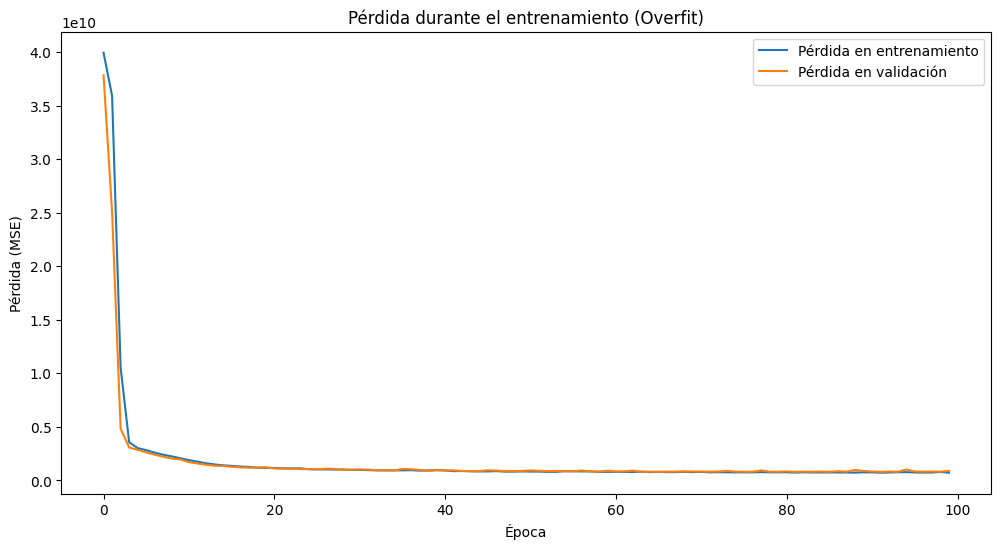

In [259]:
#Librerías generales

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Definimos la arquitectura del modelo (complejo para que se provoque el overfit)
model_overfit = Sequential()

# Capa de entrada y primera capa oculta (más neuronas para incrementar la capacidad del modelo)
model_overfit.add(Dense(500, input_dim=X_train.shape[1], activation='relu'))  # 500 neuronas

# Segunda capa oculta (más neuronas para incrementar la complejidad)
model_overfit.add(Dense(500, activation='relu'))  # 500 neuronas

# Tercera capa oculta (aún mayor complejidad)
model_overfit.add(Dense(300, activation='relu'))  # 300 neuronas

# Cuarta capa oculta (capa adicional para incrementar la capacidad)
model_overfit.add(Dense(200, activation='relu'))  # 200 neuronas

# Capa de salida (1 neurona, sin función de activación porque es regresión)
model_overfit.add(Dense(1))

# Compilar el modelo
model_overfit.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje 0.001
    loss='mse',                          # Función de pérdida: Error Cuadrático Medio (MSE)
    metrics=['mae']                      # Medidas: Error Absoluto Medio (MAE)
)

# Resumen del modelo
print("\nResumen del modelo con overfit:")
model_overfit.summary()

# Entrenamiento  del modelo
history_overfit = model_overfit.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,          # Número de épocas
    batch_size=32,       # Tamaño del lote
    verbose=1            # Mostrar el progreso
)

# Evaluación del modelo dentro del conjunto de validación
# Se asignan los resultados de la evaluación a variables específicas
val_loss_overfit, val_mae_overfit = model_overfit.evaluate(X_val, y_val, verbose=0)

# Print de los resultados de la evaluación
print(f"\nPérdida en el conjunto de validación (MSE): {val_loss_overfit:.2f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de validación: {val_mae_overfit:.2f}")

# Representación gráfica de la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history_overfit.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_overfit.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento (Overfit)')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()

# El gráfico muestra cómo la pérdida en entrenamiento cae rápidamente, mientras que la pérdida en validación comienza a aumentar, lo cual es un indicador de la presencia de overfitting.

#12. Probar 3 ejemplos con distintas regularizaciones y identificar la que mejor funciona

Para resolver el ejericio 12, vamos a probar con tres regularizaciones e identificaremos cual funciona mejor.


1.   Regularización L2 (Ridge): Penaliza los pesos grandes del modelo mediante una penalización proporcional al cuadrado de los pesos. Conviene para reducir el overfitting sin eliminar características.
2.   Regularización L1 (Lasso): Castiga pesos grandes mediante una penalización proporcional al valor absoluto de los pesos. Elimina características irrelevantes al forzar algunos pesos a cero.
3.   Dropout: técnica específica de redes neuronales que desactiva aleatoriamente neuronas durante el entrenamiento para evitar que el modelo dependa demasiado de determinadas neuronas.





In [260]:
# Recargamos las librerías generales anteriores
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Definimos una función para crear modelos con diferentes regularizaciones
def create_model_with_regularization(reg_type=None, reg_param=0.01):
    model = Sequential()

    if reg_type == 'l2':
        # Modelo con regularización L2
        model.add(Dense(200, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(reg_param)))
        model.add(Dense(200, activation='relu', kernel_regularizer=l2(reg_param)))
    elif reg_type == 'l1':
        # Modelo con regularización L1
        model.add(Dense(200, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l1(reg_param)))
        model.add(Dense(200, activation='relu', kernel_regularizer=l1(reg_param)))
    elif reg_type == 'dropout':
        # Modelo con Dropout
        model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.5))  # Desactiva el 50% de las neuronas
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.5))
    else:
        # Modelo base sin regularización
        model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(200, activation='relu'))

    # Capa de salida
    model.add(Dense(1))

    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Entrenamiento y evaluación de  cada modelo
regularizations = ['l2', 'l1', 'dropout']
results = {}

for reg in regularizations:
    print(f"\nEntrenando modelo con regularización: {reg.upper()}")

    # Creamos el modelo con la regularización correspondiente
    model = create_model_with_regularization(reg_type=reg, reg_param=0.01)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=1
    )

    # Evaluar sobre el conjunto de validación
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    results[reg] = {
        'val_loss': val_loss,
        'val_mae': val_mae
    }

    print(f"Resultado para {reg.upper()}:")
    print(f"Pérdida en validación (MSE): {val_loss:.2f}")
    print(f"Error Absoluto Medio (MAE) en validación: {val_mae:.2f}")

# Respuesta a la pregunta cuál es la regularización que funciona mejor
best_reg = min(results, key=lambda k: results[k]['val_loss'])
print("\nResumen de resultados:")
for reg, metrics in results.items():
    print(f"{reg.upper()}: Pérdida (MSE) = {metrics['val_loss']:.2f}, MAE = {metrics['val_mae']:.2f}")
print(f"\nMejor regularización: {best_reg.upper()} con pérdida (MSE) = {results[best_reg]['val_loss']:.2f}")


Entrenando modelo con regularización: L2
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 41139232768.0000 - mae: 186545.8281 - val_loss: 38224072704.0000 - val_mae: 177735.0469
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 39998074880.0000 - mae: 182495.6250 - val_loss: 38190039040.0000 - val_mae: 177645.2344
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41043152896.0000 - mae: 183859.1562 - val_loss: 38077104128.0000 - val_mae: 177346.8438
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40320438272.0000 - mae: 182749.5781 - val_loss: 37812989952.0000 - val_mae: 176647.1562
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38933630976.0000 - mae: 181312.2812 - val_loss: 37316243456.0000 - val_mae: 175323.9844
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 40372609024.0000 - mae: 184199.8125 - val_loss: 36503261184.0000 - val_mae: 173137.4219
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37597794304.0000 - mae: 178710.3438 - val_loss: 35296419840.0000 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 41811501056.0000 - mae: 185789.9062 - val_loss: 38224613376.0000 - val_mae: 177736.4219
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41392209920.0000 - mae: 185691.7500 - val_loss: 38193254400.0000 - val_mae: 177653.5781
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37649108992.0000 - mae: 179198.1094 - val_loss: 38086578176.0000 - val_mae: 177371.5781
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 40537985024.0000 - mae: 183864.3438 - val_loss: 37831598080.0000 - val_mae: 176696.0781
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37391945728.0000 - mae: 177225.9062 - val_loss: 37339717632.0000 - val_mae: 175386.0938
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39549992960.0000 - mae: 181389.2188 - val_loss: 36497334272.0000 - val_mae: 173120.6562
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37577179136.0000 - mae: 178298.0000 - val_loss: 35231485952.0000 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 38853730304.0000 - mae: 182220.9062 - val_loss: 38223163392.0000 - val_mae: 177732.5156
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39967567872.0000 - mae: 182784.0000 - val_loss: 38185517056.0000 - val_mae: 177632.9844
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40945831936.0000 - mae: 184710.5312 - val_loss: 38064590848.0000 - val_mae: 177313.1250
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39643820032.0000 - mae: 182399.1719 - val_loss: 37785444352.0000 - val_mae: 176572.8125
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41617141760.0000 - mae: 185100.5156 - val_loss: 37260320768.0000 - val_mae: 175172.0469
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37873577984.0000 - mae: 179075.8906 - val_loss: 36391190528.0000 - val_mae: 172830.1406
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37230514176.0000 - mae: 175256.8125 - val_loss: 35100438528.0000 - val